In [1]:
import keras
import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import mean_squared_error
from keras.models import Model
from tensorflow.keras import regularizers
from keras.layers import Flatten, Dense, Input, Embedding, Dot
from keras.layers import GlobalAveragePooling1D, MaxPooling1D, Dropout, BatchNormalization
from keras.optimizers import Adam

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# load data
movie = [i.strip().split("::") for i in open("/content/drive/My Drive/MovieLens10M/movies.dat").readlines()]
movie = pd.DataFrame(movie)
movie = movie.rename(columns={0: "movieId", 1: "title", 2: "genres"})
rating = [i.strip().split("::") for i in open("/content/drive/My Drive/MovieLens10M/ratings.dat").readlines()]
rating = pd.DataFrame(rating)
rating = rating.rename(columns={0: "userId", 1: "movieId", 2: "rating", 3: "timestamp"})
movie = movie.loc[:,["movieId","genres"]]
rating = rating.loc[:,["userId","movieId","rating","timestamp"]]
data = pd.merge(rating, movie)
data['rating'] = pd.to_numeric(data['rating'])
data['timestamp'] = pd.to_numeric(data['timestamp'])
print("MovieLens" + str(int(len(rating)/1000000)) + "M dataset loaded")
del(movie)
del(rating)

MovieLens10M dataset loaded


In [3]:
# preprocessing
n_movies = len(data['movieId'].unique())
n_users = len(data['userId'].unique())
genres_split = data.genres.str.split('|').tolist()
genres_unique = set()
for movie_genres in genres_split:
    for genre in movie_genres:
        genres_unique.add(genre)
genres2idx = {o:i+1 for i,o in enumerate(genres_unique)}
genres_split = [[genres2idx[x] for x in movie_genres] for movie_genres in genres_split]
padded_genres = tf.keras.preprocessing.sequence.pad_sequences(
    genres_split, padding="post"
)

users = data.userId.unique()
movies = data.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

data['userId'] = data['userId'].apply(lambda x: userid2idx[x])
data['movieId'] = data['movieId'].apply(lambda x: movieid2idx[x])
del(userid2idx)
del(movieid2idx)

n_genres = len(padded_genres[0])
data = data.drop(columns=['genres'])
for i in range(n_genres):
    data['genre'+str(i)] = padded_genres[:,i]
del(genres_split)
del(padded_genres)

min_timestamp = pd.DataFrame(data.loc[:,["movieId","timestamp"]].groupby(['movieId'], as_index=False).min())
min_timestamp = min_timestamp.sort_values(by=["movieId"], axis=0)
min_timestamp = min_timestamp.rename(columns={"timestamp": "min_timestamp"})
data = pd.merge(data, min_timestamp)
del(min_timestamp)
data['timestamp'] = data['timestamp'] - data['min_timestamp']
data['timestamp'] = data['timestamp'] / (60 * 60 * 24 * 365)
data = data.drop(columns=['min_timestamp'])
data['day'] = data['timestamp'] * 365 / (7 * 2)
data['day'] = data['day'].apply(lambda x: int(x))
days = data.day.unique()
n_days = len(days)
day2idx = {o:i for i,o in enumerate(days)}
data['day'] = data['day'].apply(lambda x: day2idx[x])
del(day2idx)
print(n_movies, n_users, n_days)
data.head(10)

10677 69878 365


,userId,movieId,rating,timestamp,genre0,genre1,genre2,genre3,genre4,genre5,genre6,genre7,day
0,0,0,5.0,0.347135,5,15,0,0,0,0,0,0,0
1,1,0,3.0,4.638027,5,15,0,0,0,0,0,0,1
2,2,0,2.5,9.015238,5,15,0,0,0,0,0,0,2
3,3,0,3.0,3.659976,5,15,0,0,0,0,0,0,3
4,4,0,4.5,8.702935,5,15,0,0,0,0,0,0,4
5,5,0,3.0,0.519782,5,15,0,0,0,0,0,0,5
6,6,0,3.0,0.520016,5,15,0,0,0,0,0,0,5
7,7,0,3.0,0.347532,5,15,0,0,0,0,0,0,0
8,8,0,1.0,4.052296,5,15,0,0,0,0,0,0,6
9,9,0,3.0,3.736893,5,15,0,0,0,0,0,0,7


In [4]:
# split train and test data
data = data.sample(frac=1) # shuffle data
train = data[:int(len(data) * 0.9)]
valid = data[int(len(data) * 0.9):]
del(data)

In [5]:
# generate model
embedding_l2 = 1e-7 * 7                                  # regularization
dense_l2 = 1e-4 * 7                                      # regularization
keras.backend.clear_session()

user_input = Input(shape=(1,), name='user_input', dtype='int32')
movie_input = Input(shape=(1,), name='movie_input', dtype='int32')
genres_input = Input(shape=(n_genres,), name='genres_input', dtype='int32')
day_input = Input(shape=(1,), name='day_input', dtype='int32')
time_input = Input(shape=(1,), name='time_input', dtype='float32')
time_root = tf.math.sqrt(time_input + 1.0)
time_square = tf.math.square(time_input)
time_vector = tf.concat([time_input, time_root, time_square], 1)

def create_model(n_user_embedding):
    n_movie_embedding = n_user_embedding
    n_genres_embedding = int(n_user_embedding / 4)

    user_embedding = Embedding(n_users, n_user_embedding, embeddings_regularizer=regularizers.l2(embedding_l2))(user_input)
    user_vector = Flatten()(user_embedding)
    movie_embedding = Embedding(n_movies, n_movie_embedding, embeddings_regularizer=regularizers.l2(embedding_l2))(movie_input)
    movie_vector = Flatten()(movie_embedding)
    genres_embedding = Embedding(len(genres_unique)+1, n_genres_embedding, mask_zero=True, embeddings_regularizer=regularizers.l2(embedding_l2/n_genres))(genres_input)
    genres_average_embedding = GlobalAveragePooling1D()(genres_embedding)
    genres_vector = Flatten()(genres_average_embedding)
    day_embedding = Embedding(n_days, int(n_user_embedding/8), embeddings_regularizer=regularizers.l2(embedding_l2))(day_input)
    day_vector = Flatten()(day_embedding)

    concat_layer = tf.concat([user_vector, movie_vector, time_vector, genres_vector, day_vector], 1)
    mlp_output = Dense(int(n_user_embedding/2), activation='relu', kernel_regularizer=regularizers.l2(dense_l2))(concat_layer)

    user_embedding2 = Embedding(n_users, n_user_embedding, embeddings_regularizer=regularizers.l2(embedding_l2))(user_input)
    user_vector2 = Flatten()(user_embedding2)
    movie_embedding2 = Embedding(n_movies, n_movie_embedding, embeddings_regularizer=regularizers.l2(embedding_l2))(movie_input)
    movie_vector2 = Flatten()(movie_embedding2)
    MF = Dot(axes=1)([user_vector2, movie_vector2])

    output_layer = tf.concat([mlp_output, MF], 1)
    return output_layer

output_layer = tf.concat([create_model(16*x) for x in range(1,9)], 1)
output = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(dense_l2))(output_layer)
output = output*5.5

model = Model([user_input, movie_input, time_input, genres_input, day_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
genres_input (InputLayer)       [(None, 8)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

In [6]:
# training
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer=Adam(1e-3 / 2), loss='mse', metrics=[rmse])
batch_size = 4096*8
epochs = 128

callback = tf.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=1, restore_best_weights=True)
history = model.fit([train.userId, train.movieId, train.timestamp, train.iloc[:,4:4+n_genres], train.day], train.rating,
                batch_size=batch_size, epochs=epochs, callbacks=[callback],
                validation_data = ([valid.userId, valid.movieId, valid.timestamp, valid.iloc[:,4:4+n_genres], valid.day], valid.rating), verbose = 1)

Epoch 1/128
275/275 [==============================] - 479s 2s/step - loss: 1.3336 - rmse: 1.0103 - val_loss: 0.8243 - val_rmse: 0.8620
Epoch 2/128
275/275 [==============================] - 451s 2s/step - loss: 0.8006 - rmse: 0.8573 - val_loss: 0.7764 - val_rmse: 0.8579
Epoch 3/128
275/275 [==============================] - 452s 2s/step - loss: 0.7597 - rmse: 0.8491 - val_loss: 0.7212 - val_rmse: 0.8258
Epoch 4/128
275/275 [==============================] - 450s 2s/step - loss: 0.6750 - rmse: 0.7954 - val_loss: 0.6715 - val_rmse: 0.7896
Epoch 5/128
275/275 [==============================] - 449s 2s/step - loss: 0.5710 - rmse: 0.7212 - val_loss: 0.6574 - val_rmse: 0.7747
Epoch 6/128
275/275 [==============================] - 451s 2s/step - loss: 0.4726 - rmse: 0.6426 - val_loss: 0.6611 - val_rmse: 0.7718
Epoch 7/128
275/275 [==============================] - 451s 2s/step - loss: 0.3857 - rmse: 0.5640 - val_loss: 0.6739 - val_rmse: 0.7758


In [7]:
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=[rmse])
history = model.fit([train.userId, train.movieId, train.timestamp, train.iloc[:,4:4+n_genres], train.day], train.rating,
                batch_size=batch_size, epochs=epochs, callbacks=[callback],
                validation_data = ([valid.userId, valid.movieId, valid.timestamp, valid.iloc[:,4:4+n_genres], valid.day], valid.rating), verbose = 1)

Epoch 1/128
275/275 [==============================] - 467s 2s/step - loss: 0.3872 - rmse: 0.5670 - val_loss: 0.6604 - val_rmse: 0.7710
Epoch 2/128
275/275 [==============================] - 457s 2s/step - loss: 0.3729 - rmse: 0.5538 - val_loss: 0.6614 - val_rmse: 0.7712


test_rmse = 0.7709050794563451


(array([3.30000e+01, 5.50000e+02, 9.25200e+03, 1.08492e+05, 4.32570e+05,
        3.39345e+05, 8.79310e+04, 1.84000e+04, 3.23000e+03, 2.03000e+02]),
 array([-4.34994769, -3.47283571, -2.59572372, -1.71861174, -0.84149976,
         0.03561223,  0.91272421,  1.78983619,  2.66694818,  3.54406016,
         4.42117214]),
 <a list of 10 Patch objects>)

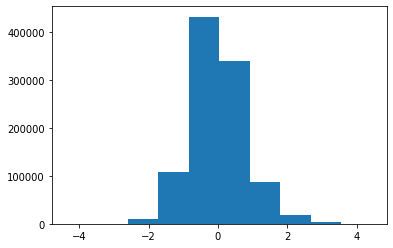

In [8]:
# check final RMSE
valid_pred = model.predict([valid.userId, valid.movieId, valid.timestamp, valid.iloc[:,4:4+n_genres], valid.day], batch_size = batch_size)
valid['pred'] = pd.DataFrame([float(x) for x in valid_pred], index=valid.index, columns=['pred'])
valid['pred'] = valid['pred'].apply(lambda x: max(min(x, 5), 0.5))

test_rmse = mean_squared_error(valid.rating, valid.pred, squared=False) # squared=False -> RMSE
print("test_rmse = " + str(test_rmse))
plt.hist(valid['pred'] - valid['rating'])